In [1]:
%load_ext autoreload
%autoreload 2

import collections
import logging
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import tensor, Tensor
from typing import Any

import weight_formats.experiments as E

logging.basicConfig(level=logging.WARNING, force=True)
matplotlib.rcParams.update({
    "axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False,
    "figure.figsize": (5, 3),
})

2025-07-29:19:30:59,986 INFO     [rouge_scorer.py:83] Using default tokenizer.
2025-07-29:19:31:00,562 INFO     [_client.py:1025] HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


## Load runs

In [2]:
runs = E.runs("20250708-qat-main", progress=True)

query: 210it [00:00, 477.44it/s]


In [3]:
def fmt_name(fmt: E.AttrDict) -> str:
    s = [{(None, None): "Tensor", (1, None): "Channel"}.get(tuple(fmt.block_shape), "Block") + f" {fmt.scaling.capitalize()}"]
    if fmt.compressor:
        s.append("Compression")
    if fmt.sparse_ratio:
        s.append("Sparse")
    return " + ".join(s).replace("Rms", "RMS")


def plot_training(d: pd.DataFrame, y: str = "step_valid_kl", x: str = "step",
                  figsize: tuple[float, float] = (3, 3), sharex: bool = True, sharey: bool = True,
                  fmt: dict[str, str] = {}, **specs: str) -> np.ndarray[matplotlib.axes.Axes]:
    """specs: (hue, style, col, row)"""
    spec_values = {k: d[v].unique() for k, v in specs.items()}
    all_values = object()
    for k in ["hue", "style", "col", "row"]:
        spec_values.setdefault(k, [all_values])

    nrows, ncols = len(spec_values["row"]), len(spec_values["col"])
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*figsize[0], nrows*figsize[1]), squeeze=False, sharex=sharex, sharey=sharey)
    palette = sns.color_palette(n_colors=len(spec_values["hue"]))
    styles = ["-", "--", ":"]
    assert len(spec_values["style"]) < len(styles)

    for axr, row_value in zip(axs, spec_values["row"]):
        for ax, col_value in zip(axr, spec_values["col"]):
            title = ", ".join(filter(None, [None if row_value is all_values else f"{specs['row']}={fmt.get(specs['row'], str)(row_value)}",
                                            None if col_value is all_values else f"{specs['col']}={fmt.get(specs['col'], str)(col_value)}"]))
            ax.set_title(title, fontsize=10)
            for hue, hue_value in zip(palette, spec_values["hue"]):
                for style, style_value in zip(styles, spec_values["style"]):
                    g = d
                    for k, v in [("hue", hue_value), ("style", style_value), ("col", col_value), ("row", row_value)]:
                        g = g if v is all_values else g[g[specs[k]] == v]
                    for _, gg in g.groupby("id"):
                        ax.plot(gg[x], gg[y], color=hue, ls=style)

            ax.set_yscale("log")
            ax.tick_params(axis="y", which="minor", labelleft=False)
            ax.yaxis.set_major_formatter("{x:.0g}")
            ax.set_xscale(matplotlib.scale.SymmetricalLogScale(ax, base=2, linthresh=d[x].pipe(lambda s: s[s!=0].min()), linscale=1/4))
            ax.set_xlim((0, d[x].max()))

    for ax in axs[-1, :]:
        ax.set_xlabel(x)
    for ax in axs[:, 0]:
        ax.set_ylabel(y)

    handles = []
    for k in ["hue", "style"]:
        if k in specs:
            handles.append(matplotlib.lines.Line2D([], [], color="none", label=specs[k]))
            handles.extend([
                matplotlib.lines.Line2D([], [], color=c, ls=s, label=fmt.get(specs[k], str)(v))
                for v, c, s in zip(
                    spec_values[k],
                    palette if k == "hue" else ["k" for _ in spec_values[k]],
                    styles if k == "style" else ["-" for _ in spec_values[k]],
                )
            ])
    fig.legend(handles=handles, bbox_to_anchor=(1, .5), loc="center left")
    fig.tight_layout()
    return axs


def load_run(run: E.AttrDict) -> dict[str, Any]:
    # Config
    d = dict(
        id=run.id,
        tag=run.config.tag,
        model=run.config.model.split("-")[-1],
    )
    if run.config.test.type == "qat":
        # Config (QAT)
        d.update(
            batch_size=run.config.train.batch_size,
            steps=run.config.train.steps,
            lr=run.config.opt.lr,
            fmt=fmt_name(run.config.test.fmt),
            element_bits=run.config.test.fmt.element_bits,
            data_parallel=run.config.exe.data_parallel,
        )
    else:
        d.update(batch_size=None, steps=None, lr=None, fmt=None, element_bits=None, data_parallel=None)
    if "train" in run.summary:
        # Training log
        d.update(
            step=torch.arange(len(run.summary.train.loss)).mul(run.config.train.log_interval).tolist(),
            step_loss=run.summary.train.loss,
            step_valid_kl=run.summary.train.valid_kl_div,
        )
    # Summary
    d.update(
        bits_per_param=run.summary.get("bits_per_param"),
        valid_kl=run.summary.get("valid_kl_div"),
        downstream={k: v.primary_score for k, v in run.summary.get("downstream", {}).items()},
        duration_hr=run.meta.duration / (60*60) if "duration" in run.meta else None,
    )
    return d


df = pd.DataFrame.from_records([
    load_run(run) for run in runs
])
df.head()

,id,tag,model,batch_size,steps,lr,fmt,element_bits,data_parallel,step,step_loss,step_valid_kl,bits_per_param,valid_kl,downstream,duration_hr
0,20250708-qat-main/tScYXZ23ky,baseline,1B,NaN,NaN,NaN,None,NaN,NaN,[0.0],[None],[0.00095602684],16.000000,0.001064,"{'socialiqa:mc': 0.46724667, 'hellaswag': 0.65...",0.122495
1,20250708-qat-main/KS6wJynNyU,baseline,3B,NaN,NaN,NaN,None,NaN,NaN,[0.0],[None],[0.00080347393],16.000000,0.000912,"{'socialiqa:mc': 0.62538383, 'hellaswag': 0.74...",0.208813
2,20250708-qat-main/zev9ClTfSs,baseline,8B,NaN,NaN,NaN,None,NaN,NaN,[0.0],[None],[0.00091089529],16.000000,0.001009,"{'socialiqa:mc': 0.64790174, 'hellaswag': 0.80...",0.228814
3,20250708-qat-main/cPgba6wDKM,direct-cast,1B,1.0,0.0,0.0,Tensor RMS + Compression,3.0,1.0,[0.0],[None],[0.51605082],3.007565,0.515736,"{'socialiqa:mc': 0.32958035, 'hellaswag': 0.55...",0.390737
4,20250708-qat-main/G5xBOc0sd1,direct-cast,1B,1.0,0.0,0.0,Tensor RMS + Sparse,3.0,1.0,[0.0],[None],[1.1893706],3.047597,1.185388,"{'socialiqa:mc': 0.36131013, 'hellaswag': 0.43...",0.424325


## Status

In [ ]:
display(collections.Counter(((run.config.model.split("-")[-1], run.meta.status) for run in runs)))
# Incomplete non-failures
display([run.meta.hostname for run in runs if run.config.tag == "qat" and "train" not in run.summary])

Counter({('3B', 'finished'): 46,
         ('1B', 'finished'): 36,
         ('8B', 'finished'): 19,
         ('3B', 'running'): 6,
         ('1B', 'failed'): 1})

['douglaso-20250708-qat-main-1-004-5lfbk',
 'douglaso-20250708-qat-main-1-001-6vpsb',
 'douglaso-20250708-qat-main-1-001-6vpsb']

In [31]:
for run in runs:
    if run.meta.status == "failed":
        display((run.config.model, run.error))

('meta-llama/Llama-3.2-1B',
 {'type': 'ConnectionError',
  'message': "Couldn't reach 'hellaswag' on the Hub (LocalEntryNotFoundError)",
  'trace': ['  File "/workspace/optimal-weight-formats/weight_formats/experiments/qat.py", line 643, in _run_worker\n    downstream={task.name: evaluate(model, task) for task in run.tasks},\n               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n',
   '  File "/workspace/optimal-weight-formats/weight_formats/experiments/qat.py", line 643, in <dictcomp>\n    downstream={task.name: evaluate(model, task) for task in run.tasks},\n                           ^^^^^^^^^^^^^^^^^^^^^\n',
   '  File "/workspace/optimal-weight-formats/weight_formats/experiments/qat.py", line 172, in evaluate\n    oe_task.download()\n',
   '  File "/workspace/optimal-weight-formats/.venv/lib/python3.11/site-packages/oe_eval/tasks/base_task.py", line 172, in download\n    self.dataset = MOUNTED_WEKA_DATASET_WRAPPER.load_dataset(\n                   ^^^^^^^^^^^^^^^

## Direct-cast

In [23]:
d = (df
    .pipe(lambda d: d[d.tag.isin(["baseline", "direct-cast"])])
    .pipe(lambda d: pd.concat([d, d.downstream.apply(pd.Series)], axis=1))
    .drop(columns=["id", "tag", "steps", "element_bits", "batch_size", "lr", "data_parallel", "duration_hr", "step", "step_loss", "step_valid_kl", "downstream"])
    .melt(id_vars=["model", "fmt", "bits_per_param", "valid_kl"], var_name="task", value_name="score")
)
d.head()

,model,fmt,bits_per_param,valid_kl,task,score
0,1B,None,16.000000,0.001064,socialiqa:mc,0.467247
1,3B,None,16.000000,0.000912,socialiqa:mc,0.625384
2,8B,None,16.000000,0.001009,socialiqa:mc,0.647902
3,1B,Tensor RMS + Compression,3.007565,0.515736,socialiqa:mc,0.329580
4,1B,Tensor RMS + Sparse,3.047597,1.185388,socialiqa:mc,0.361310


In [24]:
for model, g in d.pivot(index=["model", "fmt", "bits_per_param", "valid_kl"], columns="task", values="score").groupby("model"):
    display(g.sort_values("valid_kl").style.background_gradient())

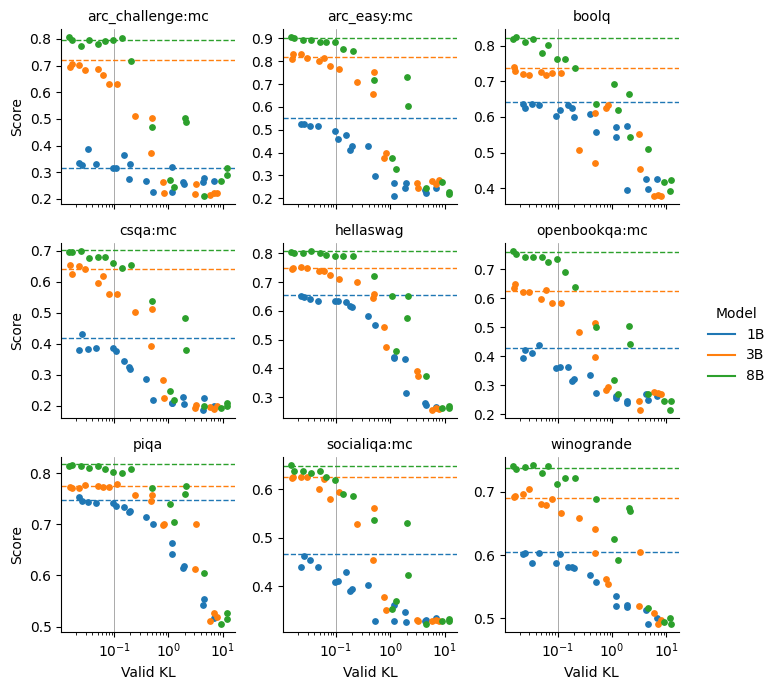

In [163]:
tasks = sorted(d.task.unique())
models = sorted(d.model.unique())
fig, axs = plt.subplots(3, 3, figsize=(7, 7), sharex=True)
for task, ax in zip(tasks, axs.flatten()):
    for model, color in zip(models, sns.color_palette()):
        g = d[(d.task == task) & (d.model == model)]
        ax.scatter(g[~g.fmt.isna()].valid_kl, g[~g.fmt.isna()].score, color=color, s=15)
        ax.axhline(g[g.fmt.isna()].score.iloc[0], color=color, ls="--", zorder=-1, lw=1)
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
    ax.axvline(0.1, color="#888", zorder=-2, lw=0.5)
    ax.set_title(task, fontsize=10)
for ax in axs[-1, :]:
    ax.set_xscale("log")
    ax.set_xlabel("Valid KL")
for ax in axs[:, 0]:
    ax.set_ylabel("Score")

fig.legend(title="Model", handles=[
    matplotlib.lines.Line2D([], [], color=color, label=model)
    for model, color in zip(models, sns.color_palette())
], bbox_to_anchor=(1, 0.5), loc="center left")
fig.tight_layout()

## QAT (initial sweep, 1B & 3B)

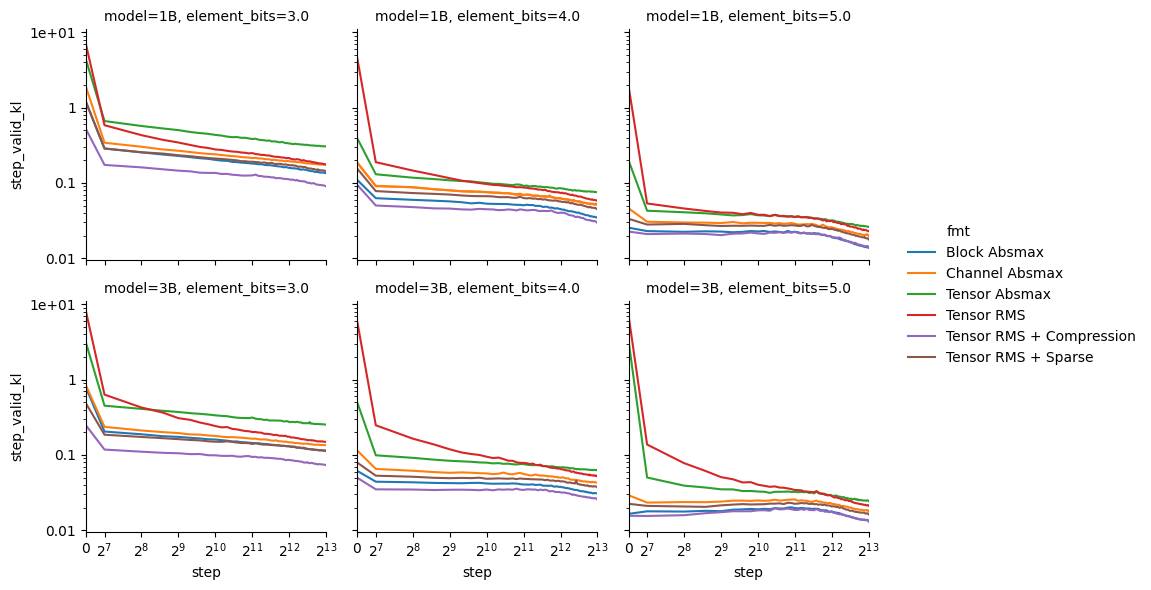

In [10]:
d = df.pipe(lambda d: d[d.tag == "qat"]).explode(["step", "step_loss", "step_valid_kl"]).reset_index().sort_values(["model", "fmt"])

axs = plot_training(d, hue="fmt", row="model", col="element_bits")

## Batch size, LR, Duration (3B, 3bpp)

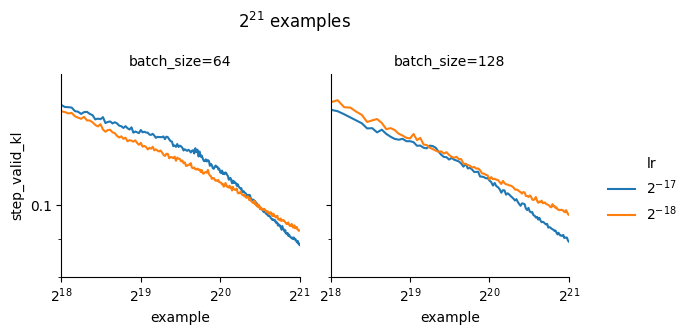

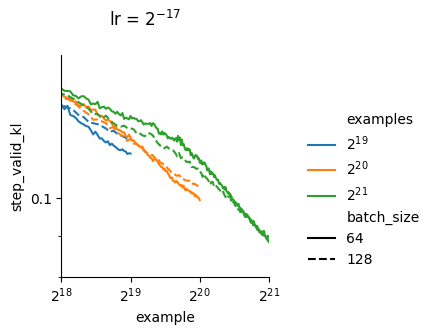

In [24]:
d = (df.pipe(lambda d: d[d.tag == "batch-lr-duration"])
     .explode(["step", "step_loss", "step_valid_kl"]).reset_index()
     .pipe(lambda d: d.assign(example=d.step * d.batch_size, examples=d.steps * d.batch_size))
)

axs = plot_training(d[d.examples==2**21], x="example", col="batch_size", hue="lr",
                    fmt=dict(batch_size=lambda x: f"{x:.0f}", lr=lambda x: f"$2^{{{tensor(x).log2().item():.0f}}}$"))
axs[0, 0].set_ylim((0.08, 0.15))
axs[0, 0].set_xlim((2**18, 2**21))
axs[0, 0].figure.suptitle("$2^{21}$ examples", y=1.1)


axs = plot_training(d[(tensor(d.lr).log2().round() == -17).numpy()], x="example", style="batch_size", hue="examples",
                    fmt=dict(batch_size=lambda x: f"{x:.0f}",
                             lr=lambda x: f"$2^{{{tensor(x).log2().item():.0f}}}$",
                             examples=lambda x: f"$2^{{{tensor(x).log2().item():.0f}}}$",
                             ))
axs[0, 0].set_ylim((0.08, 0.15))
axs[0, 0].set_xlim((2**18, 2**21))
axs[0, 0].figure.suptitle("lr = $2^{-17}$", y=1.1);

In [53]:
d = (df
    .pipe(lambda d: d[d.tag == "batch-lr-duration"])
    .pipe(lambda d: d[(tensor(list(d.lr)).log2().round() == -17).numpy()])
    .pipe(lambda d: d[d.batch_size==64])
    .pipe(lambda d: pd.concat([df[(df.tag == "baseline") & (df.model == "3B")], d]))
    [["steps", "valid_kl", "downstream"]]
    .pipe(lambda d: pd.concat([d, d.downstream.apply(pd.Series)], axis=1))
    .drop(columns="downstream")
    .set_index(["steps"])
    .style.format("{:.3f}").background_gradient()
)
d

,valid_kl,socialiqa:mc,hellaswag,openbookqa:mc,arc_challenge:mc,arc_easy:mc,csqa:mc,piqa,winogrande,boolq
steps,,,,,,,,,,
nan,0.001,0.625,0.749,0.626,0.719,0.818,0.641,0.775,0.691,0.736
8192.000000,0.114,0.576,0.714,0.546,0.569,0.767,0.550,0.755,0.664,0.721
16384.000000,0.099,0.599,0.713,0.568,0.612,0.786,0.586,0.766,0.665,0.736
32768.000000,0.088,0.604,0.723,0.548,0.582,0.779,0.566,0.763,0.660,0.726


## Bits vs LR (3B, 8B)

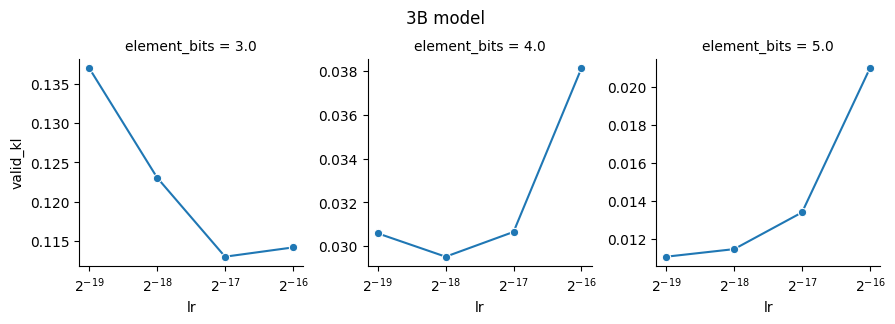

In [8]:
d = (df
    .pipe(lambda d: d[d.tag == "bits-lr"])
    .pipe(lambda d: d[~d.valid_kl.isna()])
)
g = sns.relplot(data=d, y="valid_kl", x="lr", col="element_bits", kind="line", facet_kws=dict(sharey=False), height=3, marker="o")
for _, ax in g.axes_dict.items():
    ax.set_xscale("log", base=2)
g.figure.suptitle("3B model", y=1.05);

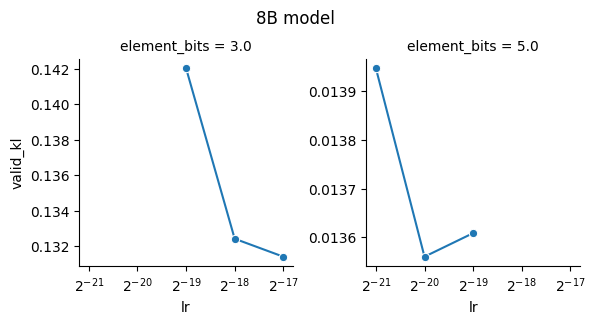

In [7]:
d = (df
    .pipe(lambda d: d[d.tag == "bits-lr-8b"])
    .pipe(lambda d: d[~d.valid_kl.isna()])
)
g = sns.relplot(data=d, y="valid_kl", x="lr", col="element_bits", kind="line", facet_kws=dict(sharey=False), height=3, marker="o")
for _, ax in g.axes_dict.items():
    ax.set_xscale("log", base=2)
g.figure.suptitle("8B model", y=1.05);

## QAT v2

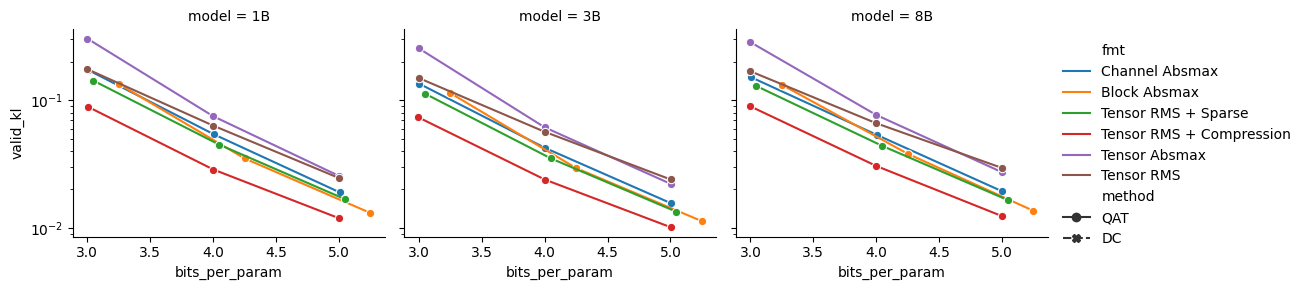

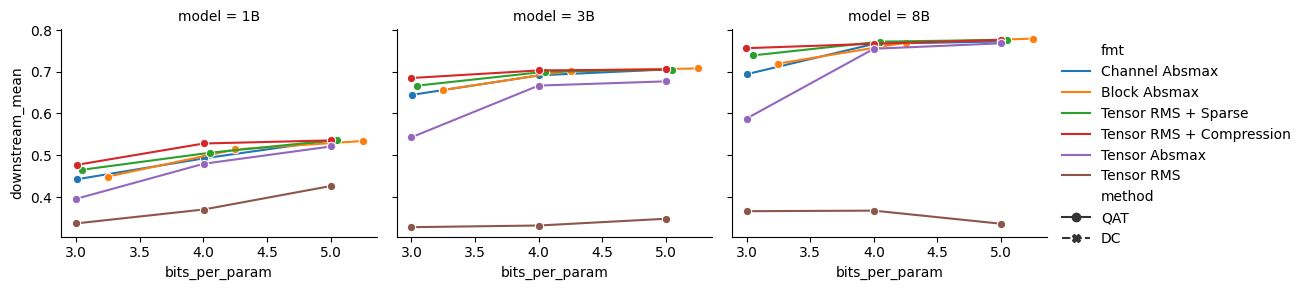

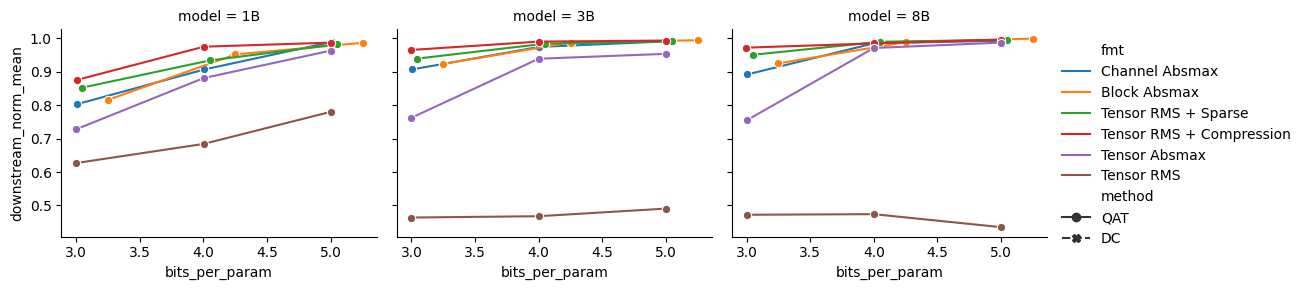

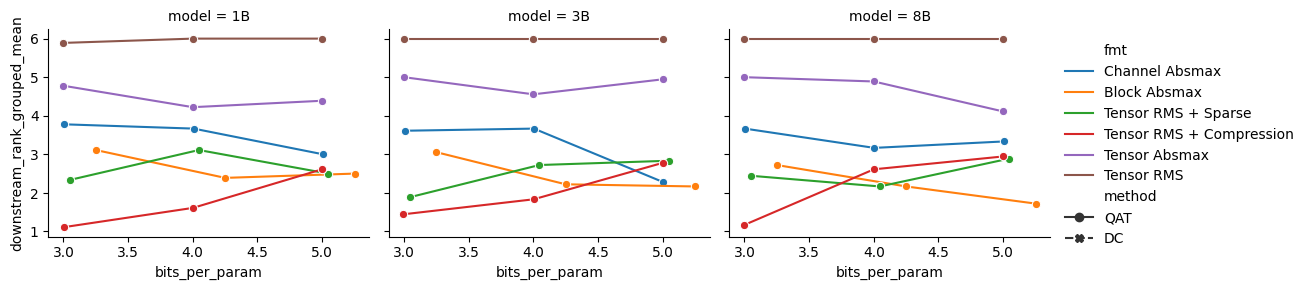

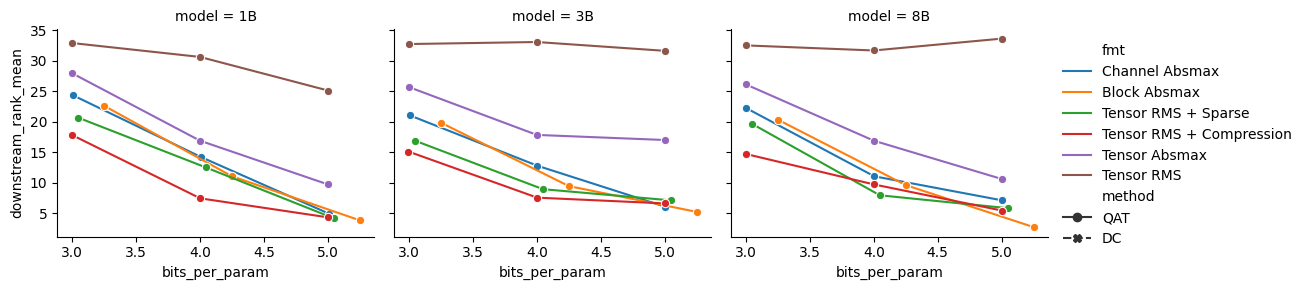

In [4]:
DOWNSTREAM_BASELINES = df.pipe(lambda d: d[d.tag == "baseline"]).pipe(lambda d: {s.model: s.downstream for _, s in d.iterrows()})

def logit(x: Tensor) -> Tensor:
    return (x / (1 - x)).log()

def accuracy_norm_mean(model: str, d: dict[str, float]) -> float:
    return tensor([
        torch.tensor(d[task] / baseline_accuracy).clip(0, 1)
        for task, baseline_accuracy in DOWNSTREAM_BASELINES[model].items()
    ]).mean().item()

d = (df
    .pipe(lambda d: d[d.tag.isin(["qat-v2", "direct-cast"])])
    .pipe(lambda d: d[~d.valid_kl.isna() & d.downstream.apply(len)])
    .pipe(lambda d: d[~d.id.isin(["20250708-qat-main/3iSIgCQZYM"])])  # failed group
    .pipe(lambda d: d.assign(method=d.steps.apply(lambda s: "QAT" if s else "DC")))
    .pipe(lambda d: d.assign(downstream_mean=d.downstream.apply(lambda d: tensor(list(d.values())).mean().item())))
    .pipe(lambda d: d.assign(downstream_logit_mean=d.downstream.apply(lambda d: logit(tensor(list(d.values()))).mean().item())))
    .pipe(lambda d: d.assign(downstream_norm_mean=d.apply(lambda s: accuracy_norm_mean(s.model, s.downstream), axis=1)))
    .groupby(["model", "element_bits", "method"]).apply(lambda g: g.assign(downstream_rank_grouped_mean=g.downstream.apply(pd.Series).rank(axis=0, method="average", ascending=False).mean(axis=1)), include_groups=False).reset_index().drop(columns="level_3")
    .groupby(["model"]).apply(lambda g: g.assign(downstream_rank_mean=g.downstream.apply(pd.Series).rank(axis=0, method="average", ascending=False).mean(axis=1)), include_groups=False).reset_index().drop(columns="level_1")
    .pipe(lambda d: d[d.method == "QAT"])
)
assert d.groupby(["model", "element_bits", "fmt", "method"]).apply(len, include_groups=False).max() == 1
for yaxis in ["valid_kl", "downstream_mean", "downstream_norm_mean", "downstream_rank_grouped_mean", "downstream_rank_mean"]:
    g = sns.relplot(data=d, y=yaxis, x="bits_per_param", hue="fmt", col="model", style="method", style_order=["QAT", "DC"],
                    kind="line", markers=True, height=3, aspect=1.2)
    if yaxis == "valid_kl":
        for ax in g.axes.flatten():
            ax.set_yscale("log")